# **Stage 1 (Data Exploration & Preprocessing)**

In [ ]:
import os
import pandas as pd

# Define the paths
base_path = '/kaggle/input/plantvillage'
dataset_path = '/kaggle/input/plantvillage/dataset'
test_path = '/kaggle/input/plantvillage/dataset/test'
train_path = '/kaggle/input/plantvillage/dataset/train'
validation_path = '/kaggle/input/plantvillage/dataset/validation'

# Function to count files in a directory and its subdirectories
def count_files(directory):
    file_count = 0
    class_counts = {}
    
    if os.path.exists(directory):
        for class_name in os.listdir(directory):
            class_dir = os.path.join(directory, class_name)
            if os.path.isdir(class_dir):
                num_files = len(os.listdir(class_dir))
                class_counts[class_name] = num_files
                file_count += num_files
    return file_count, class_counts

# Get counts for each directory
total_files, _ = count_files(dataset_path)
test_count, test_classes = count_files(test_path)
train_count, train_classes = count_files(train_path)
val_count, val_classes = count_files(validation_path)

# Create a summary DataFrame
summary = pd.DataFrame({
    'Directory': ['/kaggle/input/plantvillage', 
                 '/kaggle/input/plantvillage/dataset',
                 '/kaggle/input/plantvillage/dataset/train',
                 '/kaggle/input/plantvillage/dataset/test',
                 '/kaggle/input/plantvillage/dataset/validation'],
    'Exists': [os.path.exists(base_path),
              os.path.exists(dataset_path),
              os.path.exists(train_path),
              os.path.exists(test_path),
              os.path.exists(validation_path)],
    'Total Files': [len(os.listdir(base_path)) if os.path.exists(base_path) else 0,
                   total_files,
                   train_count,
                   test_count,
                   val_count],
    'Subdirectories': [len(os.listdir(base_path)) if os.path.exists(base_path) else 0,
                      len(os.listdir(dataset_path)) if os.path.exists(dataset_path) else 0,
                      len(train_classes),
                      len(test_classes),
                      len(val_classes)]
})

print("Dataset Structure Summary:")
print(summary)

# Show class distribution in each split
print("\nClass Distribution:")

def print_class_distribution(name, class_counts):
    print(f"\n{name} set ({sum(class_counts.values())} images):")
    for class_name, count in class_counts.items():
        print(f"  {class_name}: {count} images")

print_class_distribution("Training", train_classes)
print_class_distribution("Test", test_classes)
print_class_distribution("Validation", val_classes)

In [ ]:
# A. Class Distribution Analysis


import matplotlib.pyplot as plt
import seaborn as sns

# Convert class counts to DataFrame
train_counts = pd.DataFrame.from_dict(train_classes, orient='index', columns=['Train'])
test_counts = pd.DataFrame.from_dict(test_classes, orient='index', columns=['Test'])
val_counts = pd.DataFrame.from_dict(val_classes, orient='index', columns=['Validation'])

# Combine into one DataFrame
class_distribution = pd.concat([train_counts, test_counts, val_counts], axis=1)
class_distribution['Total'] = class_distribution.sum(axis=1)

# Plot class distribution
plt.figure(figsize=(15, 8))
sns.barplot(x=class_distribution.index, y=class_distribution['Train'])
plt.title("Training Set Class Distribution")
plt.xticks(rotation=90)
plt.ylabel("Number of Images")
plt.show()

In [ ]:
# B. Image Dimension Analysis


from PIL import Image
import numpy as np

def analyze_image_dimensions(directory, sample_size=50):
    widths, heights = [], []
    
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        images = os.listdir(class_path)[:sample_size]
        
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            with Image.open(img_path) as img:
                widths.append(img.width)
                heights.append(img.height)
    
    return widths, heights

# Analyze training set dimensions
widths, heights = analyze_image_dimensions(train_path)

print(f"Average Width: {np.mean(widths):.0f}px")
print(f"Average Height: {np.mean(heights):.0f}px")
print(f"Min Dimensions: {min(widths)}x{min(heights)}")
print(f"Max Dimensions: {max(widths)}x{max(heights)}")

# Plot distribution
plt.figure(figsize=(10, 5))
sns.scatterplot(x=widths, y=heights, alpha=0.5)
plt.title("Image Dimensions Scatter Plot")
plt.xlabel("Width (px)")
plt.ylabel("Height (px)")
plt.show()

In [ ]:
# C. Sample Image Visualization

def display_class_samples(class_name, n_samples=5):
    class_dir = os.path.join(train_path, class_name)
    sample_images = os.listdir(class_dir)[:n_samples]
    
    plt.figure(figsize=(15, 3))
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        
        plt.subplot(1, n_samples, i+1)
        plt.imshow(img)
        plt.title(f"{class_name}\n{img.size[0]}x{img.size[1]}")
        plt.axis('off')
    plt.show()

# Display samples from 3 classes
display_class_samples("Tomato__Tomato_YellowLeaf__Curl_Virus")
display_class_samples("Potato___healthy")
display_class_samples("Tomato_Leaf_Mold")


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Stronger augmentation for minority classes
augmentation = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values
    rotation_range=40,         # Rotate ±40 degrees
    width_shift_range=0.2,     # Horizontal shift
    height_shift_range=0.2,    # Vertical shift
    shear_range=0.2,           # Shear transformations
    zoom_range=0.3,            # Zoom in/out up to 30%
    horizontal_flip=True,      # Random flips
    vertical_flip=True,        # Useful for leaf images
    brightness_range=[0.7, 1.3], # Adjust brightness
    fill_mode='reflect'        # Better than 'nearest' for leaves
)

# For validation/test (only normalization)
test_val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
from sklearn.utils import class_weight
import numpy as np

# 1. Prepare the training labels array
train_labels = []
for i, class_name in enumerate(sorted(train_classes.keys())):
    train_labels.extend([i] * train_classes[class_name])
train_labels = np.array(train_labels)

# 2. Compute balanced class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# 3. Convert to dictionary format
class_weights = dict(enumerate(class_weights))

# 4. Print with class names for verification
print("Class Weights (Higher = More emphasis on minority classes):")
for i, class_name in enumerate(sorted(train_classes.keys())): 
    print(f"{i}: {class_name:45} → weight: {class_weights[i]:.2f}")

In [ ]:
batch_size = 32
target_size = (256, 256)

# Training generator with augmentation
train_generator = augmentation.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True  # Critical for augmentation
)

# Validation generator (no augmentation)
val_generator = test_val_datagen.flow_from_directory(
    validation_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # No need to shuffle validation data
)

In [ ]:
# Check class indices match your weights
print("Class Indices:", train_generator.class_indices)

In [ ]:
# Display augmented samples
augmented_images, labels = next(train_generator)
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(augmented_images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis('off')
plt.suptitle("Augmented Training Samples", y=1.05)
plt.show()

In [ ]:
import json

config = {
    'target_size': target_size,
    'batch_size': batch_size,
    'class_weights': class_weights,
    'class_indices': train_generator.class_indices,
    'augmentation_params': {
        'rotation_range': augmentation.rotation_range,
        'width_shift_range': augmentation.width_shift_range,
        'height_shift_range': augmentation.height_shift_range,
        'shear_range': augmentation.shear_range,
        'zoom_range': augmentation.zoom_range,
        'horizontal_flip': augmentation.horizontal_flip,
        'vertical_flip': augmentation.vertical_flip,
        'brightness_range': augmentation.brightness_range,
        'fill_mode': augmentation.fill_mode
    }
}

with open('preprocessing_config.json', 'w') as f:
    json.dump(config, f, indent=2)

In [ ]:
print("\nData Preparation Summary:")
print(f"- Training samples: {train_generator.samples}")
print(f"- Validation samples: {val_generator.samples}")
print(f"- Class weights: {class_weights}")
print("\nNext step: Pass these to model.fit():")
print(f"model.fit(train_generator, validation_data=val_generator, class_weight=class_weights)")

# **Stage 2: Baseline Model Development.**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def create_model():
    model = Sequential([
        Input(shape=(256, 256, 3)),
        
        # Conv Block 1
        Conv2D(32, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.2),
        
        # Conv Block 2 
        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.3),
        
        # Conv Block 3
        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.4),
        
        # Feature Extraction
        GlobalAveragePooling2D(),
        
        # Classifier Head
        Dense(384, activation='relu'),  # Balanced size
        BatchNormalization(),
        Dropout(0.5),
        Dense(15, activation='softmax')
    ])
    return model

model = create_model()
model.summary()

In [ ]:
import tensorflow as tf
model.compile(
    optimizer=Adam(learning_rate=0.0005),  # Lower LR for stability
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

In [ ]:
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)
import tensorflow as tf

# 1. Callbacks with LR schedule & more patience
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,                 # wait longer
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,                  # cut LR in half
        patience=5,                  # after 5 epochs
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        'best_baseline_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# 2. Compile (optionally switch to binary_crossentropy)
model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss='categorical_crossentropy',    # or 'binary_crossentropy'
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# 3. Train without manually setting steps_per_epoch
try:
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=30,                       # more epochs
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )
finally:
    model.save('final_baseline_model.keras')
    print("Final model saved to final_baseline_model.keras")


In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Create test generator if not already
test_generator = test_val_datagen.flow_from_directory(
    test_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator)
print(f"Test  —  Accuracy: {test_acc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predictions
y_prob = model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=class_names, 
            yticklabels=class_names, 
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))


In [ ]:
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model  # << Add this import

# Save in Keras format (recommended)
save_model(model, '/kaggle/working/plant_disease_model.keras')



model.save('/kaggle/working/plant_disease_model.h5') 
!ls /kaggle/working/
from IPython.display import FileLink
FileLink('plant_disease_model.keras')  # Creates downloadable link
!ls -lh /kaggle/working/  # Check file exists and size
# Optional: Save as H5 (legacy)
loaded_model = load_model('/kaggle/working/plant_disease_model.keras')
loaded_model.summary()    # Confirm it loads correctly

# **Stage 3 scratch‐CNN training**


In [48]:
# Cell 1 — Imports & paths
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [49]:
# Cell 2 — Generators (with correct preprocessing)
target_size = (280,280)
batch_size  = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=50,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.4,
    horizontal_flip=True,
    brightness_range=(0.6,1.4),
    fill_mode='reflect'
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    train_path, target_size=target_size,
    batch_size=batch_size, class_mode='categorical'
)
val_gen   = test_datagen.flow_from_directory(
    validation_path, target_size=target_size,
    batch_size=batch_size, class_mode='categorical'
)
test_gen  = test_datagen.flow_from_directory(
    test_path, target_size=target_size,
    batch_size=batch_size, class_mode='categorical', shuffle=False
)


Found 16504 images belonging to 15 classes.
Found 2070 images belonging to 15 classes.
Found 2064 images belonging to 15 classes.


In [50]:
# Cell 3 — Build the TL model
backbone = EfficientNetB0(
    weights='imagenet', include_top=False,
    input_shape=(*target_size,3)
)

x = GlobalAveragePooling2D()(backbone.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(15, activation='softmax')(x)

tl_model = Model(backbone.input, outputs)

# start with backbone frozen
for layer in backbone.layers:
    layer.trainable = False

tl_model.compile(
    optimizer=Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
tl_model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 280, 280, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 280, 280, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 280, 280, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 280, 280, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 281, 281, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 140, 140, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 140, 140, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 140, 140, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 140, 140, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 140, 140, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 140, 140, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,381,362 (16.71 MB)

 Trainable params: 331,791 (1.27 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [52]:
# Cell 4 — Callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_transfer_model.keras', 
                    monitor='val_accuracy', save_best_only=True, verbose=1)
]


In [53]:
# Cell 5 — Train head only
history_head = tl_model.fit(
    train_gen, validation_data=val_gen,
    epochs=10, callbacks=callbacks, verbose=1
)


Epoch 1/10
515/516 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.5809 - loss: 1.3304
Epoch 1: val_accuracy improved from -inf to 0.87536, saving model to best_transfer_model.keras
516/516 ━━━━━━━━━━━━━━━━━━━━ 389s 691ms/step - accuracy: 0.5813 - loss: 1.3289 - val_accuracy: 0.8754 - val_loss: 0.3903
Epoch 2/10
515/516 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.7965 - loss: 0.6029
Epoch 2: val_accuracy improved from 0.87536 to 0.89855, saving model to best_transfer_model.keras
516/516 ━━━━━━━━━━━━━━━━━━━━ 335s 641ms/step - accuracy: 0.7966 - loss: 0.6027 - val_accuracy: 0.8986 - val_loss: 0.3144
Epoch 3/10
515/516 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.8395 - loss: 0.4763
Epoch 3: val_accuracy improved from 0.89855 to 0.92705, saving model to best_transfer_model.keras
516/516 ━━━━━━━━━━━━━━━━━━━━ 327s 625ms/step - accuracy: 0.8395 - loss: 0.4762 - val_accuracy: 0.9271 - val_loss: 0.2512
Epoch 4/10
515/516 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.8583 - loss: 0

In [54]:
# Cell 6 — Unfreeze last 30 layers, fine-tune
for layer in backbone.layers[-30:]:
    layer.trainable = True

tl_model.compile(
    optimizer=Adam(5e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_ft1 = tl_model.fit(
    train_gen, validation_data=val_gen,
    epochs=10, callbacks=callbacks, verbose=1
)


Epoch 1/10


E0000 00:00:1745444526.752822     114 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745444526.959263     114 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745444527.389906     114 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745444527.596110     114 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 72/516 ━━━━━━━━━━━━━━━━━━━━ 4:35 621ms/step - accuracy: 0.7406 - loss: 0.8921

E0000 00:00:1745444585.253167     112 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745444585.461889     112 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745444585.874692     112 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745444586.083181     112 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.8074 - loss: 0.6139
Epoch 1: val_accuracy improved from 0.94396 to 0.95217, saving model to best_transfer_model.keras
516/516 ━━━━━━━━━━━━━━━━━━━━ 388s 675ms/step - accuracy: 0.8074 - loss: 0.6137 - val_accuracy: 0.9522 - val_loss: 0.1544
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.8874 - loss: 0.3252
Epoch 2: val_accuracy improved from 0.95217 to 0.96039, saving model to best_transfer_model.keras
516/516 ━━━━━━━━━━━━━━━━━━━━ 329s 628ms/step - accuracy: 0.8874 - loss: 0.3252 - val_accuracy: 0.9604 - val_loss: 0.1210
Epoch 3/10
515/516 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.9008 - loss: 0.2813
Epoch 3: val_accuracy improved from 0.96039 to 0.96522, saving model to best_transfer_model.keras
516/516 ━━━━━━━━━━━━━━━━━━━━ 327s 626ms/step - accuracy: 0.9008 - loss: 0.2812 - val_accuracy: 0.9652 - val_loss: 0.1061
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.9241 - loss: 0.2282
Ep

In [55]:
# Cell 7 — Unfreeze all, final fine-tuning
for layer in tl_model.layers:
    layer.trainable = True

tl_model.compile(
    optimizer=Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_ft2 = tl_model.fit(
    train_gen, validation_data=val_gen,
    epochs=10, callbacks=callbacks, verbose=1
)


Epoch 1/10


E0000 00:00:1745448097.617960     112 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745448097.808228     112 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


239/516 ━━━━━━━━━━━━━━━━━━━━ 2:55 632ms/step - accuracy: 0.7259 - loss: 0.9692

E0000 00:00:1745448282.929725     114 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745448283.118776     114 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.7607 - loss: 0.8234
Epoch 1: val_accuracy did not improve from 0.98116
516/516 ━━━━━━━━━━━━━━━━━━━━ 471s 729ms/step - accuracy: 0.7608 - loss: 0.8230 - val_accuracy: 0.9246 - val_loss: 0.2140
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.8738 - loss: 0.3868
Epoch 2: val_accuracy did not improve from 0.98116
516/516 ━━━━━━━━━━━━━━━━━━━━ 313s 599ms/step - accuracy: 0.8738 - loss: 0.3868 - val_accuracy: 0.9498 - val_loss: 0.1470
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.9044 - loss: 0.2842
Epoch 3: val_accuracy did not improve from 0.98116
516/516 ━━━━━━━━━━━━━━━━━━━━ 314s 600ms/step - accuracy: 0.9044 - loss: 0.2842 - val_accuracy: 0.9633 - val_loss: 0.1140
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.9181 - loss: 0.2400
Epoch 4: val_accuracy did not improve from 0.98116
516/516 ━━━━━━━━━━━━━━━━━━━━ 313s 599ms/step - accuracy: 0.9181 - loss: 0.2400 - val_accurac

In [56]:
# Cell 8 — Evaluate
print("Val  Accuracy:", max(history_ft2.history['val_accuracy']))
test_loss, test_acc = tl_model.evaluate(test_gen, verbose=1)[:2]
print(f"Test Accuracy: {test_acc:.4f}")


Val  Accuracy: 0.9719806909561157
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 183ms/step - accuracy: 0.9296 - loss: 0.2102
Test Accuracy: 0.9142


65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.9296 - loss: 0.2102
🔹 Loss      : 0.2440
🔹 Compile_metrics: 0.9142
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step


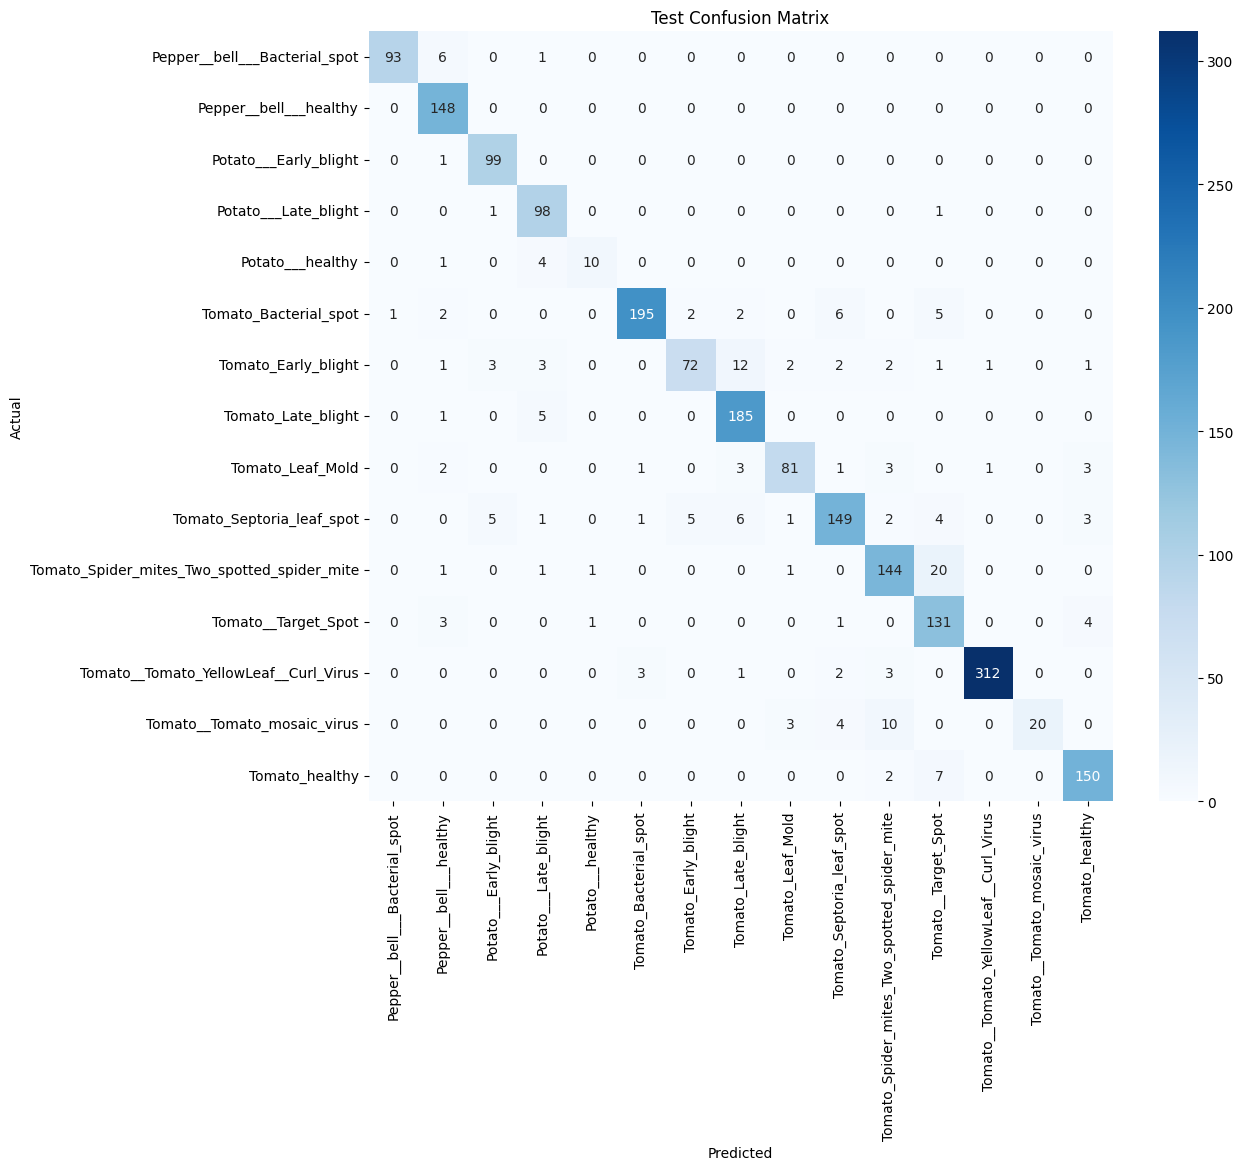


Classification Report:

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.99      0.93      0.96       100
                     Pepper__bell___healthy       0.89      1.00      0.94       148
                      Potato___Early_blight       0.92      0.99      0.95       100
                       Potato___Late_blight       0.87      0.98      0.92       100
                           Potato___healthy       0.83      0.67      0.74        15
                      Tomato_Bacterial_spot       0.97      0.92      0.94       213
                        Tomato_Early_blight       0.91      0.72      0.80       100
                         Tomato_Late_blight       0.89      0.97      0.92       191
                           Tomato_Leaf_Mold       0.92      0.85      0.89        95
                  Tomato_Septoria_leaf_spot       0.90      0.84      0.87       177
Tomato_Spider_mites_Two_spotted_spider_

In [61]:
# ─── Final Test Evaluation & Confusion Matrix ────────────────────────────

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1) Evaluate on test set
results = tl_model.evaluate(test_gen, verbose=1)
for name, val in zip(tl_model.metrics_names, results):
    print(f"🔹 {name.capitalize():<10}: {val:.4f}")

# 2) Confusion matrix & classification report
y_prob = tl_model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Confusion Matrix')
plt.xticks(rotation=90), plt.yticks(rotation=0)
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


In [57]:
# ─── Cell 9 — Save the Best & Final Models ─────────────────────────────────────

# You already have a ModelCheckpoint('best_transfer_model.keras') callback,
# so the best weights (by val_accuracy) are in best_transfer_model.keras.

# But let’s be explicit:

# 1) Save the best‐so‐far (already written by the callback):
#    best_transfer_model.keras

# 2) After all fine‐tuning, save your final weights:
tl_model.save('/kaggle/working/final_transfer_model.keras')
print("✅ Final transfer model saved to /kaggle/working/final_transfer_model.keras")

# Optional legacy H5:
tl_model.save('/kaggle/working/final_transfer_model.h5')


✅ Final transfer model saved to /kaggle/working/final_transfer_model.keras


65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.9143 - loss: 0.2694 - precision: 0.9195 - recall: 0.9100

🔹 Test Set Metrics:
   • loss     : 0.3654
   • compile_metrics: 0.8842
65/65 ━━━━━━━━━━━━━━━━━━━━ 18s 178ms/step


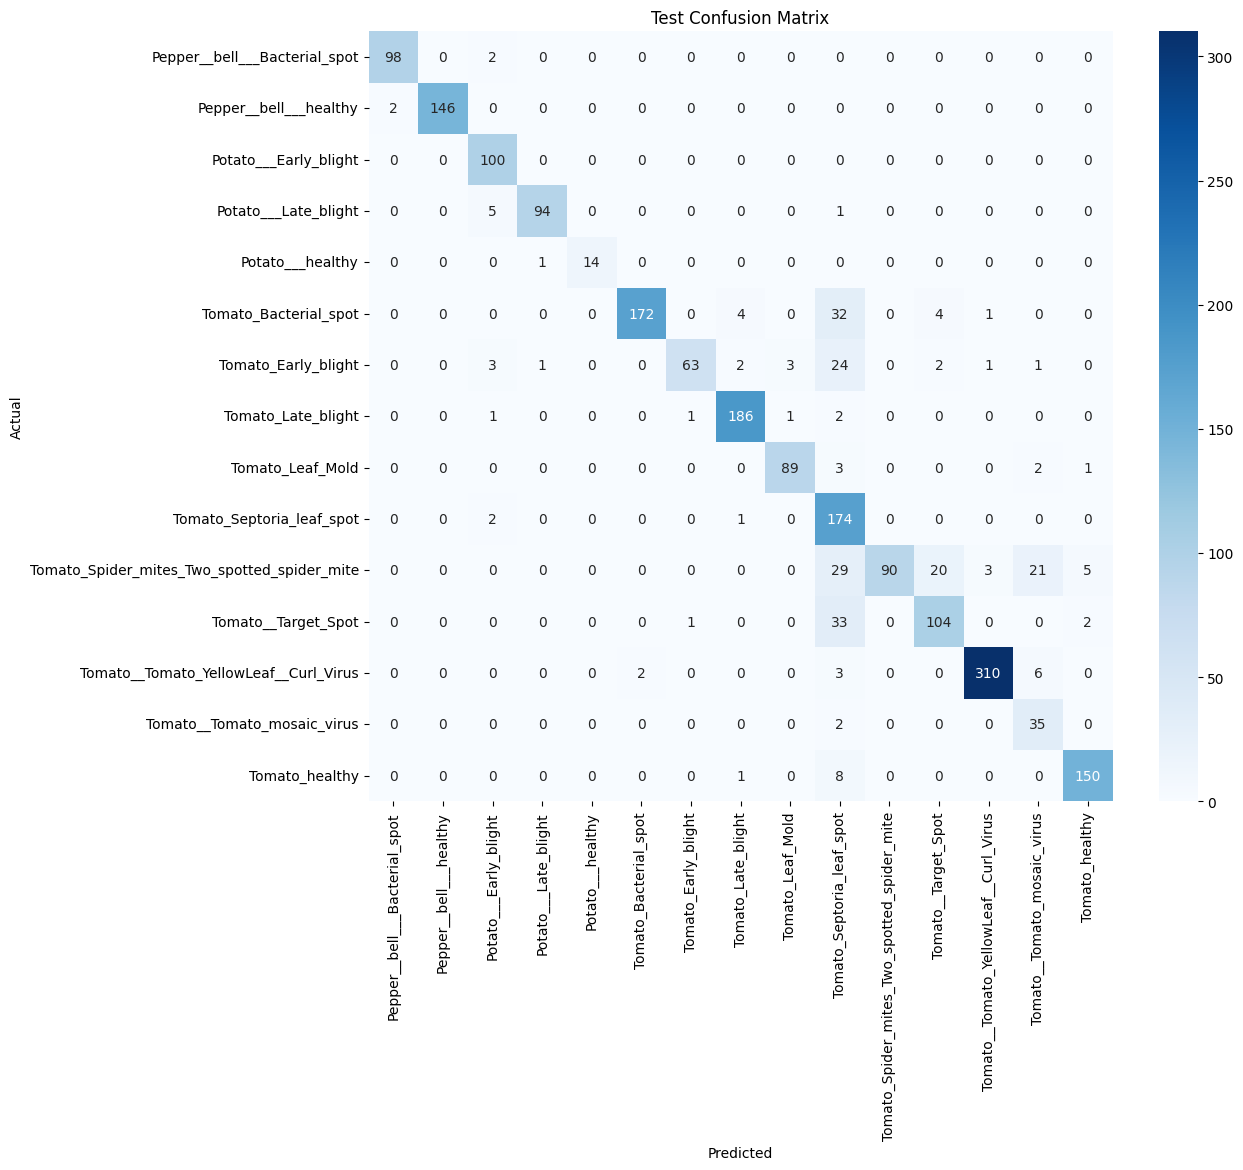


Classification Report:

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.98      0.98      0.98       100
                     Pepper__bell___healthy       1.00      0.99      0.99       148
                      Potato___Early_blight       0.88      1.00      0.94       100
                       Potato___Late_blight       0.98      0.94      0.96       100
                           Potato___healthy       1.00      0.93      0.97        15
                      Tomato_Bacterial_spot       0.99      0.81      0.89       213
                        Tomato_Early_blight       0.97      0.63      0.76       100
                         Tomato_Late_blight       0.96      0.97      0.97       191
                           Tomato_Leaf_Mold       0.96      0.94      0.95        95
                  Tomato_Septoria_leaf_spot       0.56      0.98      0.71       177
Tomato_Spider_mites_Two_spotted_spider_

In [62]:
# ─── Cell: Reload Best Transfer Model & Evaluate ───────────────────────

from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1) Load the checkpoint that saved the best val_accuracy
best = load_model('best_transfer_model.keras')

# 2) (Re)compile so metrics_names align
best.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', 
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

# 3) Evaluate on test set
results = best.evaluate(test_gen, verbose=1)
print("\n🔹 Test Set Metrics:")
for name, val in zip(best.metrics_names, results):
    print(f"   • {name:<9}: {val:.4f}")

# 4) Confusion matrix & classification report
y_prob = best.predict(test_gen, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Confusion Matrix')
plt.xticks(rotation=90), plt.yticks(rotation=0)
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


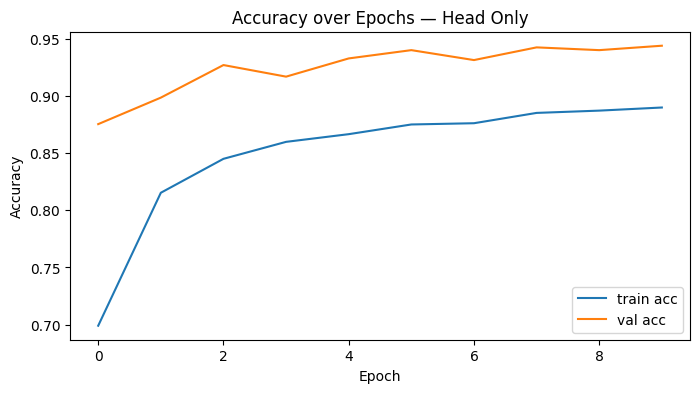

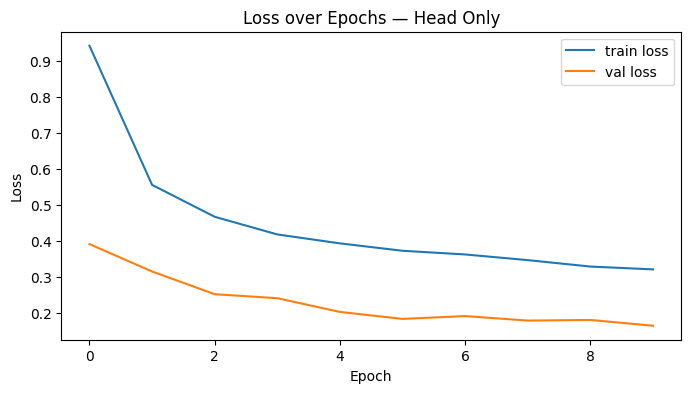

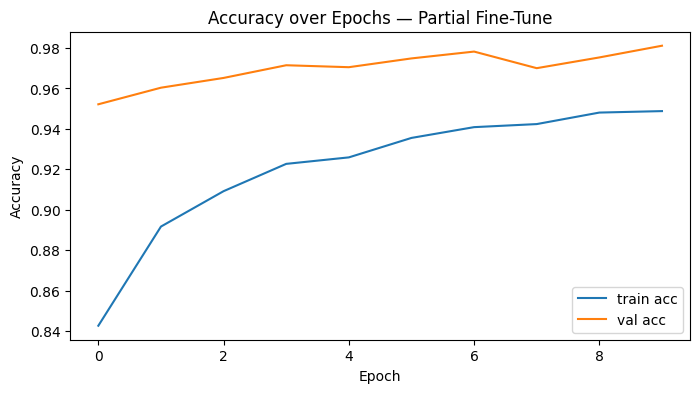

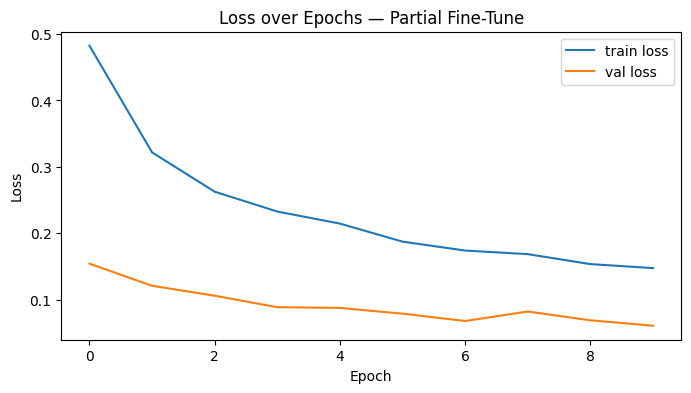

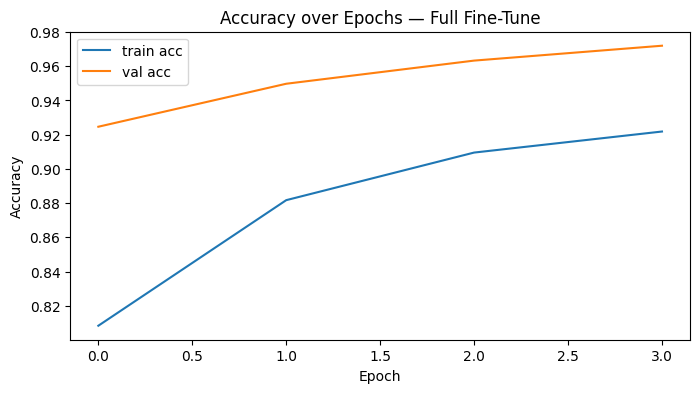

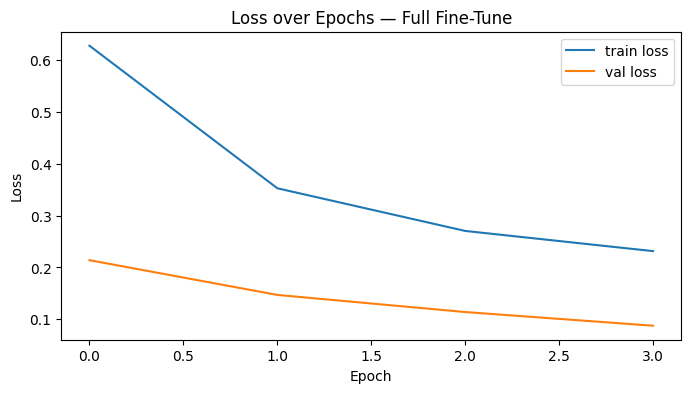

In [58]:
# ─── Cell 10 — Plot Training Curves ────────────────────────────────────────────

import matplotlib.pyplot as plt

def plot_history(hist, title_suffix=""):
    # accuracy
    plt.figure(figsize=(8,4))
    plt.plot(hist.history['accuracy'],     label='train acc')
    plt.plot(hist.history['val_accuracy'], label='val acc')
    plt.title(f'Accuracy over Epochs {title_suffix}')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.legend(); plt.show()
    
    # loss
    plt.figure(figsize=(8,4))
    plt.plot(hist.history['loss'],     label='train loss')
    plt.plot(hist.history['val_loss'], label='val loss')
    plt.title(f'Loss over Epochs {title_suffix}')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.legend(); plt.show()

# Plot each phase if you kept their histories:
plot_history(history_head, "— Head Only")
plot_history(history_ft1, "— Partial Fine-Tune")
plot_history(history_ft2, "— Full Fine-Tune")


65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.9296 - loss: 0.2102
🔹 Loss      : 0.2440
🔹 Compile_metrics: 0.9142
65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 157ms/step


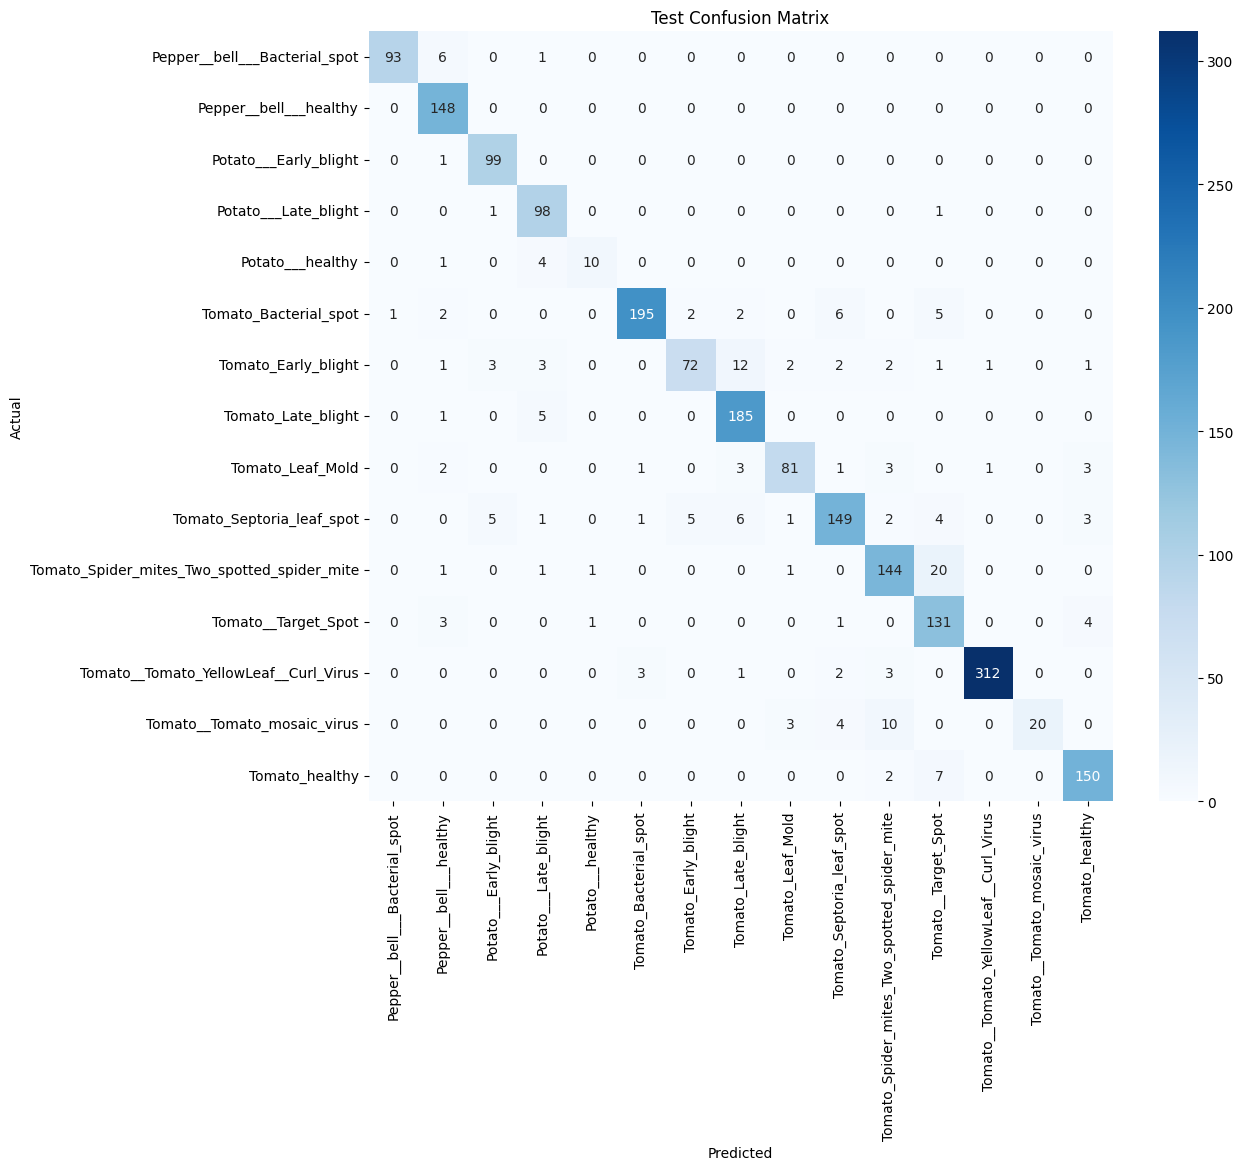


Classification Report:

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.99      0.93      0.96       100
                     Pepper__bell___healthy       0.89      1.00      0.94       148
                      Potato___Early_blight       0.92      0.99      0.95       100
                       Potato___Late_blight       0.87      0.98      0.92       100
                           Potato___healthy       0.83      0.67      0.74        15
                      Tomato_Bacterial_spot       0.97      0.92      0.94       213
                        Tomato_Early_blight       0.91      0.72      0.80       100
                         Tomato_Late_blight       0.89      0.97      0.92       191
                           Tomato_Leaf_Mold       0.92      0.85      0.89        95
                  Tomato_Septoria_leaf_spot       0.90      0.84      0.87       177
Tomato_Spider_mites_Two_spotted_spider_

In [60]:
# ─── Cell 11 — Final Evaluation & Confusion Matrix ────────────────────────────

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Evaluate on test set and print whatever metrics are available
results = tl_model.evaluate(test_gen, verbose=1)
names   = tl_model.metrics_names  # e.g. ['loss','accuracy','precision','recall']
for name, val in zip(names, results):
    print(f"🔹 {name.capitalize():<10}: {val:.4f}")

# 2) Confusion matrix & classification report
y_prob = tl_model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))
